In [1]:
from numba import float32,int32,int8,jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32,xoroshiro128p_uniform_float64
from numba.cuda.random import xoroshiro128p_normal_float32
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import math
from util import *
import torch
from torch import nn

# Using the decompression functions from data generation

In [2]:
@cuda.jit
def decompress2D(inn,states):
    """Inverse function of compress
    Note: This is slightly changed to work with the correct tensor shape"""
    sz,_,sx,sy=states.shape
    #n is which 2d grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the 2d grid
    state=states[n][0]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        x = idx//sy
        y = idx%sy
        #make it a snake pattern. . .
        if x%2==1:
            y=sy-y-1
        state[x][y]=1&(num>>bit)

@cuda.jit
def decompress1D(inn,states):
    """Similar to decompress 2D but instead of being an inverse to compress it squishes the 2D
    array output into a 1D array (which is now in a snake pattern)
    if states has shape [N,X,1] then out should have shape [M,Z/8]
    and the blocks/threads should have shape [N,Z/8]
    Here Z=X*Y where each state has shape [X,Y] on a 2D grid
    
    Note: This is slightly changed to work with the correct tensor shape
    """
    #n is which grid ur on, i is which set of 8 numbers you're on
    n,i=cuda.grid(2)
    #get the grid
    state=states[n]
    num = inn[n][i]
    for bit in range(8):
        idx=i*8+bit
        #get each value in 1d
        state[idx][0]=1&(num>>bit)

In [3]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [4]:
#bsize=1024
#N=32

#bsize=2048
#N=16

bsize=4096
N=8

B=0.25

modeltype='2d'

epoch = 3

# Implementing a simple RNN model

In [5]:
class RNN(nn.Module):
    def __init__(self,device=device, **kwargs):
        super(RNN, self).__init__()
        
        self.rnn = nn.RNN(input_size=1,hidden_size=128,batch_first=True)
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        self.device=device
        self.to(device)
    def forward(self, input):
        # h0 has shape [N,L,H]
        h0=torch.zeros([1,input.shape[0],128]).to(device)
        out,h=self.rnn(input,h0)
        return self.lin(out)

# Using a 2D RNN

https://github.com/FlorianPfisterer/2D-LSTM-Seq2Seq/blob/master/model/lstm2d_cell.py

THIS IMPLEMENTATION LEAKS GPU MEMORY SOMEWHERE!!!

In [6]:
class LSTM2dCell(nn.Module):
    """
    A 2d-LSTM Cell that computes it's hidden state and cell state based on
        - an input x
        - the previous horizontal hidden and cell state
        - the previous vertical hidden and cell state
    Args:
        input_dim: the input dimension (i.e. second dimension of x)
        state_dim: dimension of the hidden and cell state of this LSTM unit
        device: the device (CPU / GPU) to run all computations on / store tensors on
    """

    def __init__(self, input_dim, state_dim,N, device):
        super(LSTM2dCell, self).__init__()
        self.input_dim = input_dim
        self.state_dim = state_dim
        self.device = device

        # input to state
        self.W_x = nn.Linear(self.input_dim, self.state_dim * 5).to(self.device)
        # previous horizontal hidden state to state
        self.W_hor = nn.Linear(self.state_dim, self.state_dim * 5).to(self.device)
        # previous vertical hidden state to state
        self.W_ver = nn.Linear(self.state_dim, self.state_dim * 5).to(self.device)
        
        self.N=N
        self.lin = nn.Sequential(
                nn.Linear(state_dim,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            ).to(device)
        self.setup()
    def forward_pass(self, x, s_prev_hor, s_prev_ver, c_prev_hor, c_prev_ver):
        """
        Forward pass of the 2d-LSTM Cell at horizontal step j and vertical step i (to compute c_ji and s_ji)
        Args:
            x: (batch x input_dim) input at horizontal step j
            s_prev_hor: (batch x state_dim) hidden state of cell at previous horizontal step j-1, same vertical step i
            s_prev_ver: (batch x state_dim) hidden state of cell at previous vertical step i-1, same horizontal step j
            c_prev_hor: (batch x state_dim) cell state of cell at previous horizontal step j-1, same vertical step i
            c_prev_ver: (batch x state_dim) cell state of cell at previous vertical step i-1, same horizontal step j
        Returns:
            c: (batch x state_dim) next cell state (c_ji)
            s: (batch x state_dim) next hidden state (s_ji)
        """
        pre_activation = self.W_x(x) + self.W_hor(s_prev_hor) + self.W_ver(s_prev_ver)
        gates = pre_activation[:, :4*self.state_dim].sigmoid()

        # retrieve input, forget, output and lambda gate from gates
        i = gates[:, 0*self.state_dim:1*self.state_dim]
        f = gates[:, 1*self.state_dim:2*self.state_dim]
        o = gates[:, 2*self.state_dim:3*self.state_dim]
        l = gates[:, 3*self.state_dim:4*self.state_dim]

        c_candidate = pre_activation[:, 4*self.state_dim:].tanh()
        c = f * (l * c_prev_hor + (1 - l) * c_prev_ver) + c_candidate * i
        s = c.tanh() * o

        return c, s
        
    def setup(self):
        """Sets up the structure that tells the rnn how to propogate the vertical and horizontal states.
        Notably: X stores where to look for the previous rnn state in the vertical direction
                 Y stores where to look for the previous rnn state in the horizontal direction
                 Z stores where to save the current rnn output
        """
        print(self.N**2-1)
        N=self.N
        self.X=np.zeros([N**2-1],dtype=np.int64)
        self.Y=np.zeros([N**2-1],dtype=np.int64)
        Z=np.arange(N**2).reshape(N,N)
        Z[1::2,:]=Z[1::2,::-1]
        #Z is in the snake pattern
        Z=Z.reshape(N**2)[:N**2-1]
        #pad states outside with the index of the starting state
        states=np.pad(np.arange(N**2).reshape(N,N),[1,1],constant_values=N*(N-1))
        for idx in range(N**2-1):
            self.Y[idx]=states[Z[idx]//N+1,Z[idx]%N+2*((idx//N)%2)]
            self.X[idx]=states[Z[idx]//N,Z[idx]%N+1]
        self.Z=Z
        
    def forward(self,input):
        N=self.N
        X,Y,Z=self.X,self.Y,self.Z
        #set up array to store hidden states
        H,C= [True]*N**2,[True]*N**2
        #set the starting state to zero
        H[N*(N-1)]=C[N*(N-1)]=torch.zeros([input.shape[0],self.state_dim],device=device)
        out = torch.zeros(input.shape,device=self.device)
        read=[]
        for idx in range(N**2-1):
            #get horizontal input states
            hx,cx=H[X[idx]],C[X[idx]]
            #get vertical input states
            hy,cy=H[Y[idx]],C[Y[idx]]
            #get output states
            cnext,hnext=self.forward_pass(input[:,idx,:],hx,hy,cx,cy)
            #store output states for later use
            C[Z[idx]],H[Z[idx]] = cnext,hnext
            #apply linear layer
            out[:,idx,:]=self.lin(hnext)
        return out


# Visualizing 2D RNN Propogation

Note 1: The bottom left (in state sources) stores the zero state

Note 2: To get the position of the hidden state input in the propogation figures, just look for the cell in state sources with the matching color

15


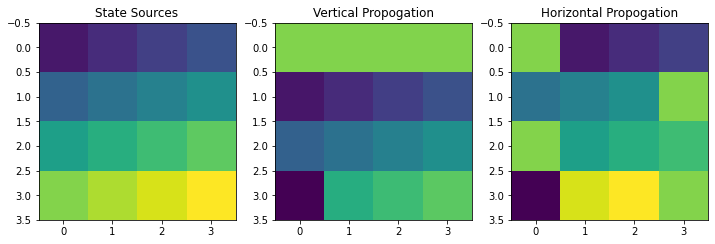

In [7]:
plt.rcParams["figure.figsize"]= [12,4]
tst = LSTM2dCell(1,128,4,device)
X,Y = np.zeros(4**2)-1,np.zeros(4**2)-1
X[tst.Z]=tst.X
Y[tst.Z]=tst.Y
X=X.reshape(4,4)
Y=Y.reshape(4,4)
Z=np.arange(16).reshape(4,4)

fig,(a1,a2,a3)=plt.subplots(1,3)
a1.imshow(Z,vmax=15,vmin=-1)
a1.set_title("State Sources")
a2.imshow(X,vmax=15,vmin=-1)
a2.set_title("Vertical Propogation")
a3.imshow(Y,vmax=15,vmin=-1)
a3.set_title("Horizontal Propogation")
plt.show()

# Setting Parameters for what model to train

In [8]:
traindata = np.load('data/traindata%d-%d.npy'%(N,B*10000))

In [9]:
#traindata = traindata[:traindata.shape[0]//5]

In [10]:
traindata = traindata[np.random.permutation(traindata.shape[0])]
traindata.shape

(51200000, 8)

In [11]:
#traindata=traindata[:512000]

# Making sure the shape of everything lines up

In [12]:
batch=torch.zeros([bsize,N*N,1]).to(device)
decompress1D[(bsize,N//2),(1,N//4)](traindata[0:bsize],batch)
if modeltype=='CNN':
    data=torch.zeros([bsize,1,N,N]).to(device)
    decompress2D[(bsize,N//2),(1,N//4)](traindata[0:bsize],data)
else:
    data=batch[:,:-1,:]
label=batch[:,1:,:]
print(data.shape,label.shape)
print(data[:,:,0])

torch.Size([4096, 63, 1]) torch.Size([4096, 63, 1])
tensor([[1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.]], device='cuda:0')


# Initialize the network

In [13]:


typedict={'2d':LSTM2dCell(1,128,N,device),'':RNN()}

net = typedict[modeltype]
with torch.no_grad():
    print(net(data).shape)

#training parameters
lr = 1e-4 *(bsize/2048)
beta1 = 0.9
beta2=0.999
#Using adam to optimize
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
)

63
torch.Size([4096, 63, 1])


# Make sure to use a loss which will give you probabilities in your predictions.

I know L2 loss and Binary Cross Entropy Loss will do this

In [14]:
Loss = nn.BCELoss()
losses=[]
validation=[]
vidx= traindata.shape[0]//bsize-1
print(vidx)

12499


# Network actually trains in a few epochs

In [15]:

#set the last batch to validation
#this is a super lazy validation set 

count=0
for i in range(epoch):
    #decided the last batch is validation 
    p = np.random.permutation(traindata.shape[0]//bsize)
    t=time.time()
    for idx in p:
        #decompress the traindata with the gpu
        decompress1D[(bsize,N//2),(1,N//4)](traindata[bsize*idx:bsize*(idx+1)],batch)
        #starting N**2-1 are inputs
        if modeltype=='CNN':
            decompress2D[(bsize,N//2),(1,N//4)](traindata[0:bsize],data)
        else:
            data=batch[:,:-1,:]
        #ending N**2-1 are predictions
        real=batch[:,1:,:]
        
        pred = net(data)
        loss = Loss(pred,real)
        net.zero_grad()
        if idx!=vidx:
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
        else:
            validation.append(loss.cpu().item())
        count+=1
        if (count%500)==0:
            print("|",end="")
            plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
            plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
            plt.yscale("log")
            plt.savefig("Loss.png")
            plt.close()
            torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    if epoch//100==0 or i%(epoch//100)==0:
        print("%.5f, %ds"%(np.mean(losses[-p.size-1:]),time.time()-t),end="| ")
        torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))

|||||||||||||||||||||||||0.61918, 1286s| |||||||||||||||||||||||||0.61841, 1279s| |||||||||||||||||||||||||0.61839, 1280s| 

In [16]:
#print(np.where(p==idx))

In [17]:
torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))

# Plotting training loss

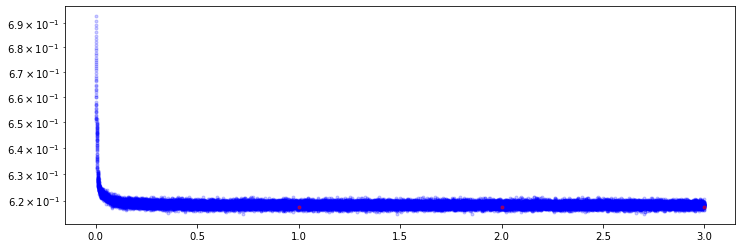

In [18]:
plt.plot(np.arange(len(losses))/vidx,losses,'.',color=(0,0,1,0.2))
plt.plot(np.arange(len(validation))+1,validation,'.',color=(1,0,0,0.5))
plt.yscale("log")
plt.show()
plt.close()

# Testing Our Output

In [19]:
testdata=np.load('data/testdata%d.npy'%N)

# Computing True and Predicted Energies

Note: To go from probability to energy we look at the relation:

$P(s)=\frac{exp(-\beta H(s))}{Z} = \frac{1}{2} \prod_{i=2}^{N^2}p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1) $

So

$ln(P(s)) = -\beta H(s) - ln(Z) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]$

$-\beta H(s) = -ln(2)+ \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]+ln(Z)$

$H(s) = \frac{ln(2)- \sum_{i=2}^{N^2}ln\big[p(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)\big]}{\beta }-\frac{ln(Z)}{\beta}$

In [20]:
@cuda.jit
def IsingEnergy(grids,E):
    """Compute Energy of 2D ising lattice (J=1 h=0)"""
    z,i,j=cuda.grid(3)
    sz,sx,sy=grids.shape
    s1=grids[z][i][j]*2-1
    s2=grids[z][(i+1)%sx][j]*2-1
    s3=grids[z][i][(j+1)%sy]*2-1
    cuda.atomic.add(E,z,-s1*s2-s1*s3)

def trueEnergies(grids,N):
    """Compute the true energies of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],1,N,N]).to(device)
    decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    testbatch=testbatch.squeeze(1)
    E=np.zeros(grids.shape[0])
    IsingEnergy[(grids.shape[0],N//8,N//8),(1,8,8)](testbatch,E)
    return E

def logprobability(grids,N):
    """compute the logscale probability of a set of data-compressed ising lattices"""
    testbatch=torch.zeros([grids.shape[0],N*N,1]).to(device)
    decompress1D[(grids.shape[0],N//2),(1,N//4)](grids,testbatch)
    if modeltype=='CNN':
        data=torch.zeros([grids.shape[0],1,N,N]).to(device)
        decompress2D[(grids.shape[0],N//2),(1,N//4)](grids,data)
    else:
        data=testbatch[:,:-1,:]
    real=testbatch[:,1:,:]
    #real is going to be a set of actual values
    #and pred is going to be a set of probabilities
    #if real[i]=1 than you muptiply your conditional probability by pred[i]
    #if real[i]=0 than you muliply by 1-pred[i]
    with torch.no_grad():
        pred = net(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
    #this is the sum you see in the cell above
    logp=torch.sum(torch.log(total),dim=1).squeeze(1)-np.log(2)
    return logp
    


# Looking at performance on Validation & Test Sets

Note: The validation set has the same distribution of states as the training set
Note: The test set has a very different distribution than our training set: States with energy zero and above will never actually have been seen by our network

In [21]:
def plot_sets(ax0,ax1,c,diff=False,name=''):
    """Creates a plot of predicted vs true energy labels for the rnn
       Since the rnn energy is relative, I set the average rnn ground state energy to the true ground state energy.
       The rest of the energies can then be calculated relative to the ground state.
    """
    # if the bytes are zero then all bits are zero
    ground = np.zeros([2,N*N//8],dtype=np.uint8)
    # if the value of the byte is 255 then all bits are 1
    ground[1]=255
    gprob = logprobability(ground,N)
    gE = trueEnergies(ground,N)
    off=-(gprob.cpu()/B).mean()-gE.mean()
    
    prob = logprobability(traindata[bsize*vidx:bsize*(vidx+1)],N)
    trueE = trueEnergies(traindata[bsize*vidx:bsize*(vidx+1)],N)
    relE=-prob.cpu()/B
    #off=relE.mean()-trueE.mean()
    print(off)
    probB = logprobability(testdata[::max(N**2//8**2-1,1)].copy(),N)
    trueEB = trueEnergies(testdata[::max(N**2//8**2-1,1)].copy(),N)
    relEB=-probB.cpu()/B
    if diff:
        ax0.plot(trueE,relE-off-trueE,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE*0,'k--')
        ax1.plot(trueEB,relEB-off-trueEB,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB*0,'k--')
    else:
        ax0.plot(trueE,relE-off,'.',color=c+[0.1],label=name)
        ax0.plot(trueE,trueE,'k--')
        ax1.plot(trueEB,relEB-off,'.',color=c+[0.1],label=name)
        ax1.plot(trueEB,trueEB,'k--')

tensor(194.3594)


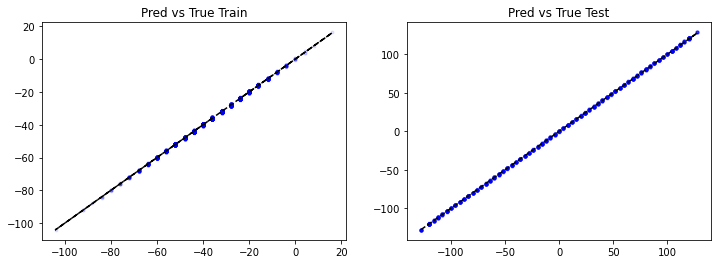

In [22]:
plt.rcParams["figure.figsize"]= [12,4]
fig,(ax0,ax1)=plt.subplots(1,2)
plot_sets(ax0,ax1,[0,0,1])
ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
plt.show()

# Comparing results at different epochs

63
tensor(194.4340)
63
tensor(193.5056)
63
tensor(194.3594)


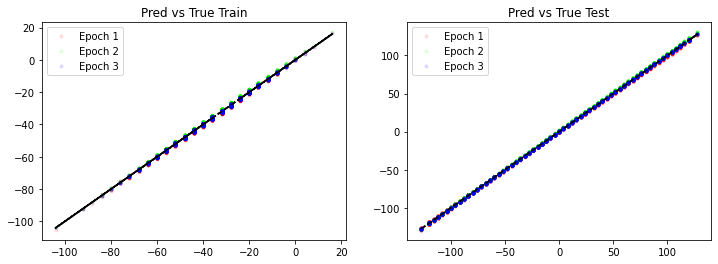

tensor(194.4340)
tensor(193.5056)
tensor(194.3594)


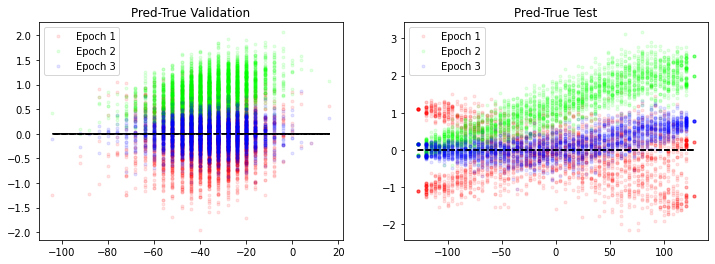

In [23]:
fig,(ax0,ax1)=plt.subplots(1,2)

colors = [[1,0,0],[0,1,0],[0,0,1]]
for i in range(epoch):
    net = torch.load("models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    net.setup()
    torch.save(net,"models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    plot_sets(ax0,ax1,colors[i],name='Epoch %d'%(i+1))


ax0.set_title("Pred vs True Train")
ax1.set_title("Pred vs True Test")
ax0.legend()
ax1.legend()
plt.show()

fig,(ax0,ax1)=plt.subplots(1,2)

for i in range(epoch):
    net = torch.load("models/%s%d-%d-%d"%(modeltype,N,B*10000,i))
    #net.setup()
    plot_sets(ax0,ax1,colors[i],True,name='Epoch %d'%(i+1))
ax0.set_title("Pred-True Validation")
ax1.set_title("Pred-True Test")
ax0.legend()
ax1.legend()
plt.show()